# MONTE CARLO Analysis for NPV calcs

### Import File

In [1]:
# Steps:
# For n in range(10,000):
# 	Sample from uncertainty distribution for each parameter
# 	Calculate number of counties with NPV>0 (or other outcome?) with the parameters
# Plot histogram of 10,000 outcomes

import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fil = 'MonteCarloInput.xlsx'
df = pd.read_excel(fil)

total_health = df['Total Annual Health Savings']
private_health = df['Private Annual Health Savings']
retrofit_cost = df['Total Retrofit Cost']
energy_savings = df['Energy Savings']
households = df['Households <200FPL per county']
scc=df['Avoided Emissions Benefits']
sum_households = np.sum(households)

### Run Monte Carlo

In [2]:
import time

start=time.time()

n=10000#10000
retrofit_lifetime=30 #MAKE SURE to update if this has changed

#initialize final metric array
median_totalc_NPV = np.zeros(n) 
median_total_NPV = np.zeros(n) 
median_private_NPV = np.zeros(n)
median_energy_NPV = np.zeros(n)

posNPV_totalc = np.zeros(n)
posNPV_total = np.zeros(n)
posNPV_private = np.zeros(n)
posNPV_energy = np.zeros(n)


for i in range(n):
    #Assign Random
    discount_rate = random.uniform(0.01, 0.06)
    energy_prices_adj = random.uniform (-0.15,0.28) #percentages taken from EIA energy analysis
    health_costs_adj = random.triangular(-0.5,0,0.5) 
    retrofit_cost_adj = random.triangular(-0.5,0,0.5)
        
    energy_savings2 = energy_savings*(1+energy_prices_adj) #for each county
    # adjust both private and public health savings
    total_health2 = total_health*(1+health_costs_adj) #for each county
    private_health2 = private_health*(1+health_costs_adj) #for each county
    retrofit_cost2 = retrofit_cost*(1+retrofit_cost_adj) #for each county

    #Do NPV Calculation
    private_benefits = private_health2+energy_savings2
    private_NPV = private_benefits/discount_rate*(1-np.exp(-2*retrofit_lifetime*discount_rate)) - retrofit_cost2
    
    total_benefits = total_health2+energy_savings2
    total_NPV = total_benefits/discount_rate*(1-np.exp(-2*retrofit_lifetime*discount_rate)) - retrofit_cost2
    
    #benefits including social cost of carbon no longer included in results
    totalc_benefits = total_health+energy_savings2+scc
    totalc_NPV = totalc_benefits/discount_rate*(1-np.exp(-2*retrofit_lifetime*discount_rate)) - retrofit_cost2
    
    energy_NPV = energy_savings2/discount_rate*(1-np.exp(-2*retrofit_lifetime*discount_rate)) - retrofit_cost2
    
    #calculate pop-weighted median of all counties 
    median_totalc_NPV[i] = np.nanmedian(totalc_NPV*households)/sum_households# for each county
    median_total_NPV[i] = np.nanmedian(total_NPV*households)/sum_households# for each county
    median_private_NPV[i] = np.nanmedian(private_NPV*households)/sum_households
    median_energy_NPV[i] = np.nanmedian(energy_NPV*households)/sum_households
    
    #calculate % of counties with NPV>0
    num_counties=3107

    posNPV_totalc[i] = np.sum(total_NPV>0)/num_counties
    posNPV_total[i] = np.sum(total_NPV>0)/num_counties
    posNPV_private[i] = np.sum(private_NPV>0)/num_counties
    posNPV_energy[i] = np.sum(energy_NPV>0)/num_counties
    
end = time.time()
print(str(end-start))

102.59945130348206


### Plot Results

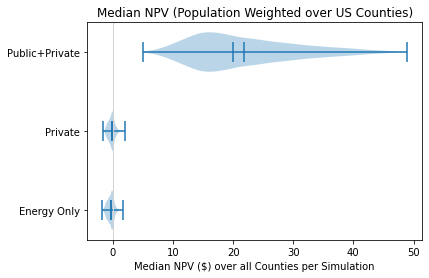

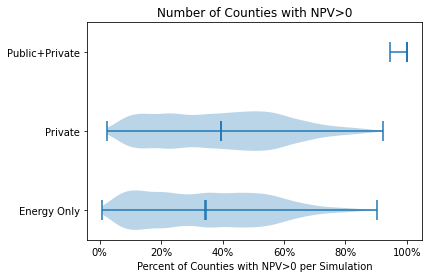

In [3]:
from matplotlib.ticker import FuncFormatter


#Violin Plots of Metrics
fig, ax = plt.subplots()
# build a violin plot
ax.violinplot(np.column_stack((median_energy_NPV, median_private_NPV, median_total_NPV)), 
              vert=False, showmeans=True, showmedians=True)

# add title and axis labels
ax.set_title('Median NPV (Population Weighted over US Counties)')
# ax.set_xlabel('')
ax.set_xlabel('Median NPV ($) over all Counties per Simulation')

# add x-tick labels
yticklabels = ['Energy Only', 'Private', 'Public+Private']
ax.set_yticks([1,2,3])
ax.set_yticklabels(yticklabels)

# add horizontal grid lines
# ax.yaxis.grid(True)
plt.axvline(0, color='lightgrey',linewidth='1')
fig.set_figwidth(6)
fig.set_figheight(4)
# show the plot
plt.show()

fig, ax = plt.subplots()
# build a violin plot
ax.violinplot(np.column_stack((posNPV_energy,posNPV_private,posNPV_total)), 
              vert=False, showmeans=True, showmedians=True)

# add title and axis labels
ax.set_title('Number of Counties with NPV>0')
# ax.set_xlabel('')
ax.set_xlabel('Percent of Counties with NPV>0 per Simulation')

# add x-tick labels
xticklabels = ['Energy Only', 'Private', 'Public+Private']
ax.set_yticks([1,2,3])
ax.set_yticklabels(yticklabels)
# current_values = plt.gca().get_xticks()
# plt.gca().set_xticklabels(['{:,.0%}'.format(x) for x in current_values])
f = lambda x, pos: f'{x*100:,.0f}%'
ax.xaxis.set_major_formatter(FuncFormatter(f))
# add horizontal grid lines
# ax.yaxis.grid(True)
fig.set_figwidth(6)
fig.set_figheight(4)
# show the plot
plt.show()

Text(0.5, 0.98, 'Number of Counties with NPV>0')

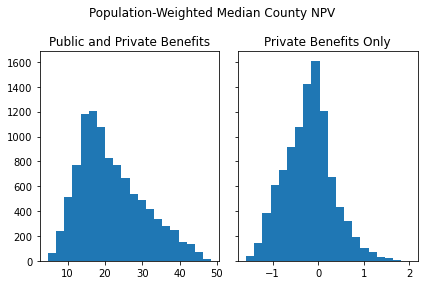

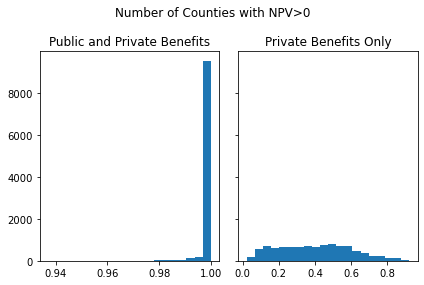

In [5]:
#plot histograms of metrics
n_bins = 20

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(median_total_NPV, bins=n_bins)
axs[1].hist(median_private_NPV, bins=n_bins)

axs[0].title.set_text('Public and Private Benefits')
axs[1].title.set_text('Private Benefits Only')
fig.suptitle('Population-Weighted Median County NPV')
    
n_bins = 20

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

axs[0].hist(posNPV_total, bins=n_bins)
axs[1].hist(posNPV_private, bins=n_bins)
axs[0].title.set_text('Public and Private Benefits')
axs[1].title.set_text('Private Benefits Only')
fig.suptitle('Number of Counties with NPV>0')